# Particle physics results

## Setup

In [23]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score

sys.path.append("../../")
from experiments.simulators.collider import WBFLoader
import plot_settings as ps


In [24]:
ps.setup()

## Helper functions

In [25]:
def histo_w_err(
    xvals, xmin, xmax, nbins,
    ls="-", m=" ", ms=6., c="black",
    label=None, alpha=0.1,
    subtract_min=False, plot_individual=False,
    **kwargs
):
    # Calculate histograms
    histos = []
    for x in xvals:
        histo, bin_edges = np.histogram(x, bins=nbins, range=(xmin, xmax), density=True)
        histos.append(histo)
    histos = np.array(histos)

    # Mean and error band
    y_mean, y_err = np.nanmean(histos, axis=0), np.nanstd(histos, axis=0)
    
    x_ = np.repeat(bin_edges, 2)[1:-1]
    y_ = np.repeat(y_mean, 2)
    y_err_ = np.repeat(y_err, 2)
    yis_ = [np.repeat(y, 2) for y in histos]
    
    # Plot
    plt.fill_between(x_, y_ - y_err_, y_ + y_err_, color=c, alpha=alpha)
    plt.plot(x_, y_, label=label, ls=ls, marker=m, ms=ms, c=c, lw=1.5, **kwargs)
    
    if plot_individual:
        for yi_ in yis_:
            plt.plot(x_, yi_, ls=ls, lw=0.5, c=c)
    

## Load results

In [28]:
n_runs = 5
n_chains = 4
n_trueparams = 3
n_panels = 4

remove_all_results_with_nans = False

In [47]:
algo_filenames = []
algo_additionals = []
algo_labels = []
algo_colors = []
algo_markers = []
algo_linestyles = []
algo_2ds = []
algo_panels = []
algo_best_runs = []

def add_algo(filename, add, label, c, m, ls, panel, best_run, lhc2d=False):
    algo_filenames.append(filename)
    algo_additionals.append(add)
    algo_labels.append(label)
    algo_colors.append(c)
    algo_markers.append(m)
    algo_linestyles.append(ls)
    algo_2ds.append(lhc2d)
    algo_panels.append(panel)
    algo_best_runs.append(best_run)
    
add_algo("flow", "_april", "2D summaries", ps.COLOR_AF2D, "s", "-", 0, 2, True)
add_algo("flow", "_april", "AF", ps.COLOR_AF, "^", "-", 1, 2)
add_algo("pie", "_april", "PIE", ps.COLOR_PIE, "<", "-", 2, 0) 
# add_algo("mf", "_alternate_april", "MFMF-A", ps.COLOR_FLMA, "o", "-", 3, 0)
# add_algo("gamf", "_april", "MFMF-OT", ps.COLOR_FLMOT, "v", "--", 1, 0) 
# add_algo("gamf", "_alternate_april", "MFMF'-OTA", ps.COLOR_FLMOTA, ">", "--", 1, 0) 
# add_algo("emf", "_alternate_april", "MFMF'-A", ps.COLOR_FLMEA, "D", "--", 1, 0)

n_algos = len(algo_filenames)

In [36]:
def load(name, shape, numpyfy=True, chains=1, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add, algo_2d in zip(algo_filenames, algo_additionals, algo_2ds):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)

            try:
                this_result = np.load(
                    "{}/{}_{}_lhc{}{}{}_{}.npy".format(
                        result_dir, algo_filename, "2" if algo_2d else "14",
                        "2d" if algo_2d else "", algo_add, run_str, name
                    )
                )
                if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                    algo_results.append(this_result.reshape(shape))
                else:
                    algo_results.append(np.nan*np.ones(shape))

            except FileNotFoundError as e:
                # print(e)
                if shape is None:
                    algo_results.append(None)
                else:
                    algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    if numpyfy:
        all_results = np.array(all_results, dtype=np.float)
        
    return all_results


model_gen_x = load("samples", None, numpyfy=False)
model_gen_closure = load("samples_manifold_distance", (10000,))


In [37]:
def load_mcmc(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add, algo_2d in zip(algo_filenames, algo_additionals, algo_2ds):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)
            
            for trueparam in range(n_trueparams):
                trueparam_str = "" if trueparam == 0 else "_trueparam{}".format(trueparam)
            
                for chain in range(n_chains):
                    chain_str = "" if chain == 0 else "_chain{}".format(chain)

                    try:
                        this_result = np.load(
                            "{}/{}_{}_lhc{}{}{}_{}{}{}.npy".format(
                                result_dir, algo_filename, "2" if algo_2d else "14",
                                "2d" if algo_2d else "", algo_add, run_str, name, trueparam_str, chain_str
                            )
                        )
                        if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                            algo_results.append(this_result.reshape(shape))
                        else:
                            algo_results.append(np.nan*np.ones(shape))

                    except FileNotFoundError as e:
                        # print(e)
                        if shape is None:
                            algo_results.append(None)
                        else:
                            algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    all_results = np.array(all_results, dtype=np.float)
    all_results = all_results.reshape([all_results.shape[0], n_runs, n_trueparams, n_chains] + list(shape))
        
    return all_results


model_posterior_samples = load_mcmc("posterior_samples", (500, 2,))
model_posterior_samples.shape  # (algo, run, true param id, chain, sample, theta component)


(3, 5, 3, 4, 500, 2)

In [38]:
sim = WBFLoader()

test_x, _ = sim.load_dataset(train=False, dataset_dir="../data/samples/lhc", numpy=True)

test_closure = sim.distance_from_manifold(test_x)

In [39]:
def remove_nans(*results):
    passes = all([np.all(np.isfinite(result)) for result in results])
    
    if passes:
        return results
    else:
        return [np.nan * np.ones_like(result) for result in results]


def remove_nans_from_lists(*raws):
    # raws[quantity][algo]
    n_quantities = len(raws)
    n_algos = len(raws[0])
    
    for raw in raws:
        assert len(raw) == n_algos
    
    cleans = [[[] for _ in range(n_algos)] for _ in range(n_quantities)]
    
    for i in range(n_algos):
        for k in range(n_runs):
            clean = remove_nans(*[raw[i][k] for raw in raws])
            for j in range(n_quantities):
                cleans[j][i].append(clean[j])
            
    cleans = [np.array(clean) for clean in cleans]
    
    # cleans[quantity][algo]
    return cleans
   
if remove_all_results_with_nans:
    raw = [model_gen_closure, model_posterior_samples]
    clean = remove_nans_from_lists(*raw)
    model_gen_closure, model_posterior_samples = clean


In [40]:
madminer_mcmc_samples = np.load("../data/results/madminer_lhc_posterior_samples.npy")

## Calculate metrics

In [41]:
n_observed = 100
min_logp = -100.
max_closure = 1.e9

test_mean_closure = np.mean(np.clip(test_closure, None, max_closure), axis=-1)
model_gen_mean_closure = np.mean(np.clip(model_gen_closure, None, max_closure), axis=2)


## Generative mode: closure test

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: inval

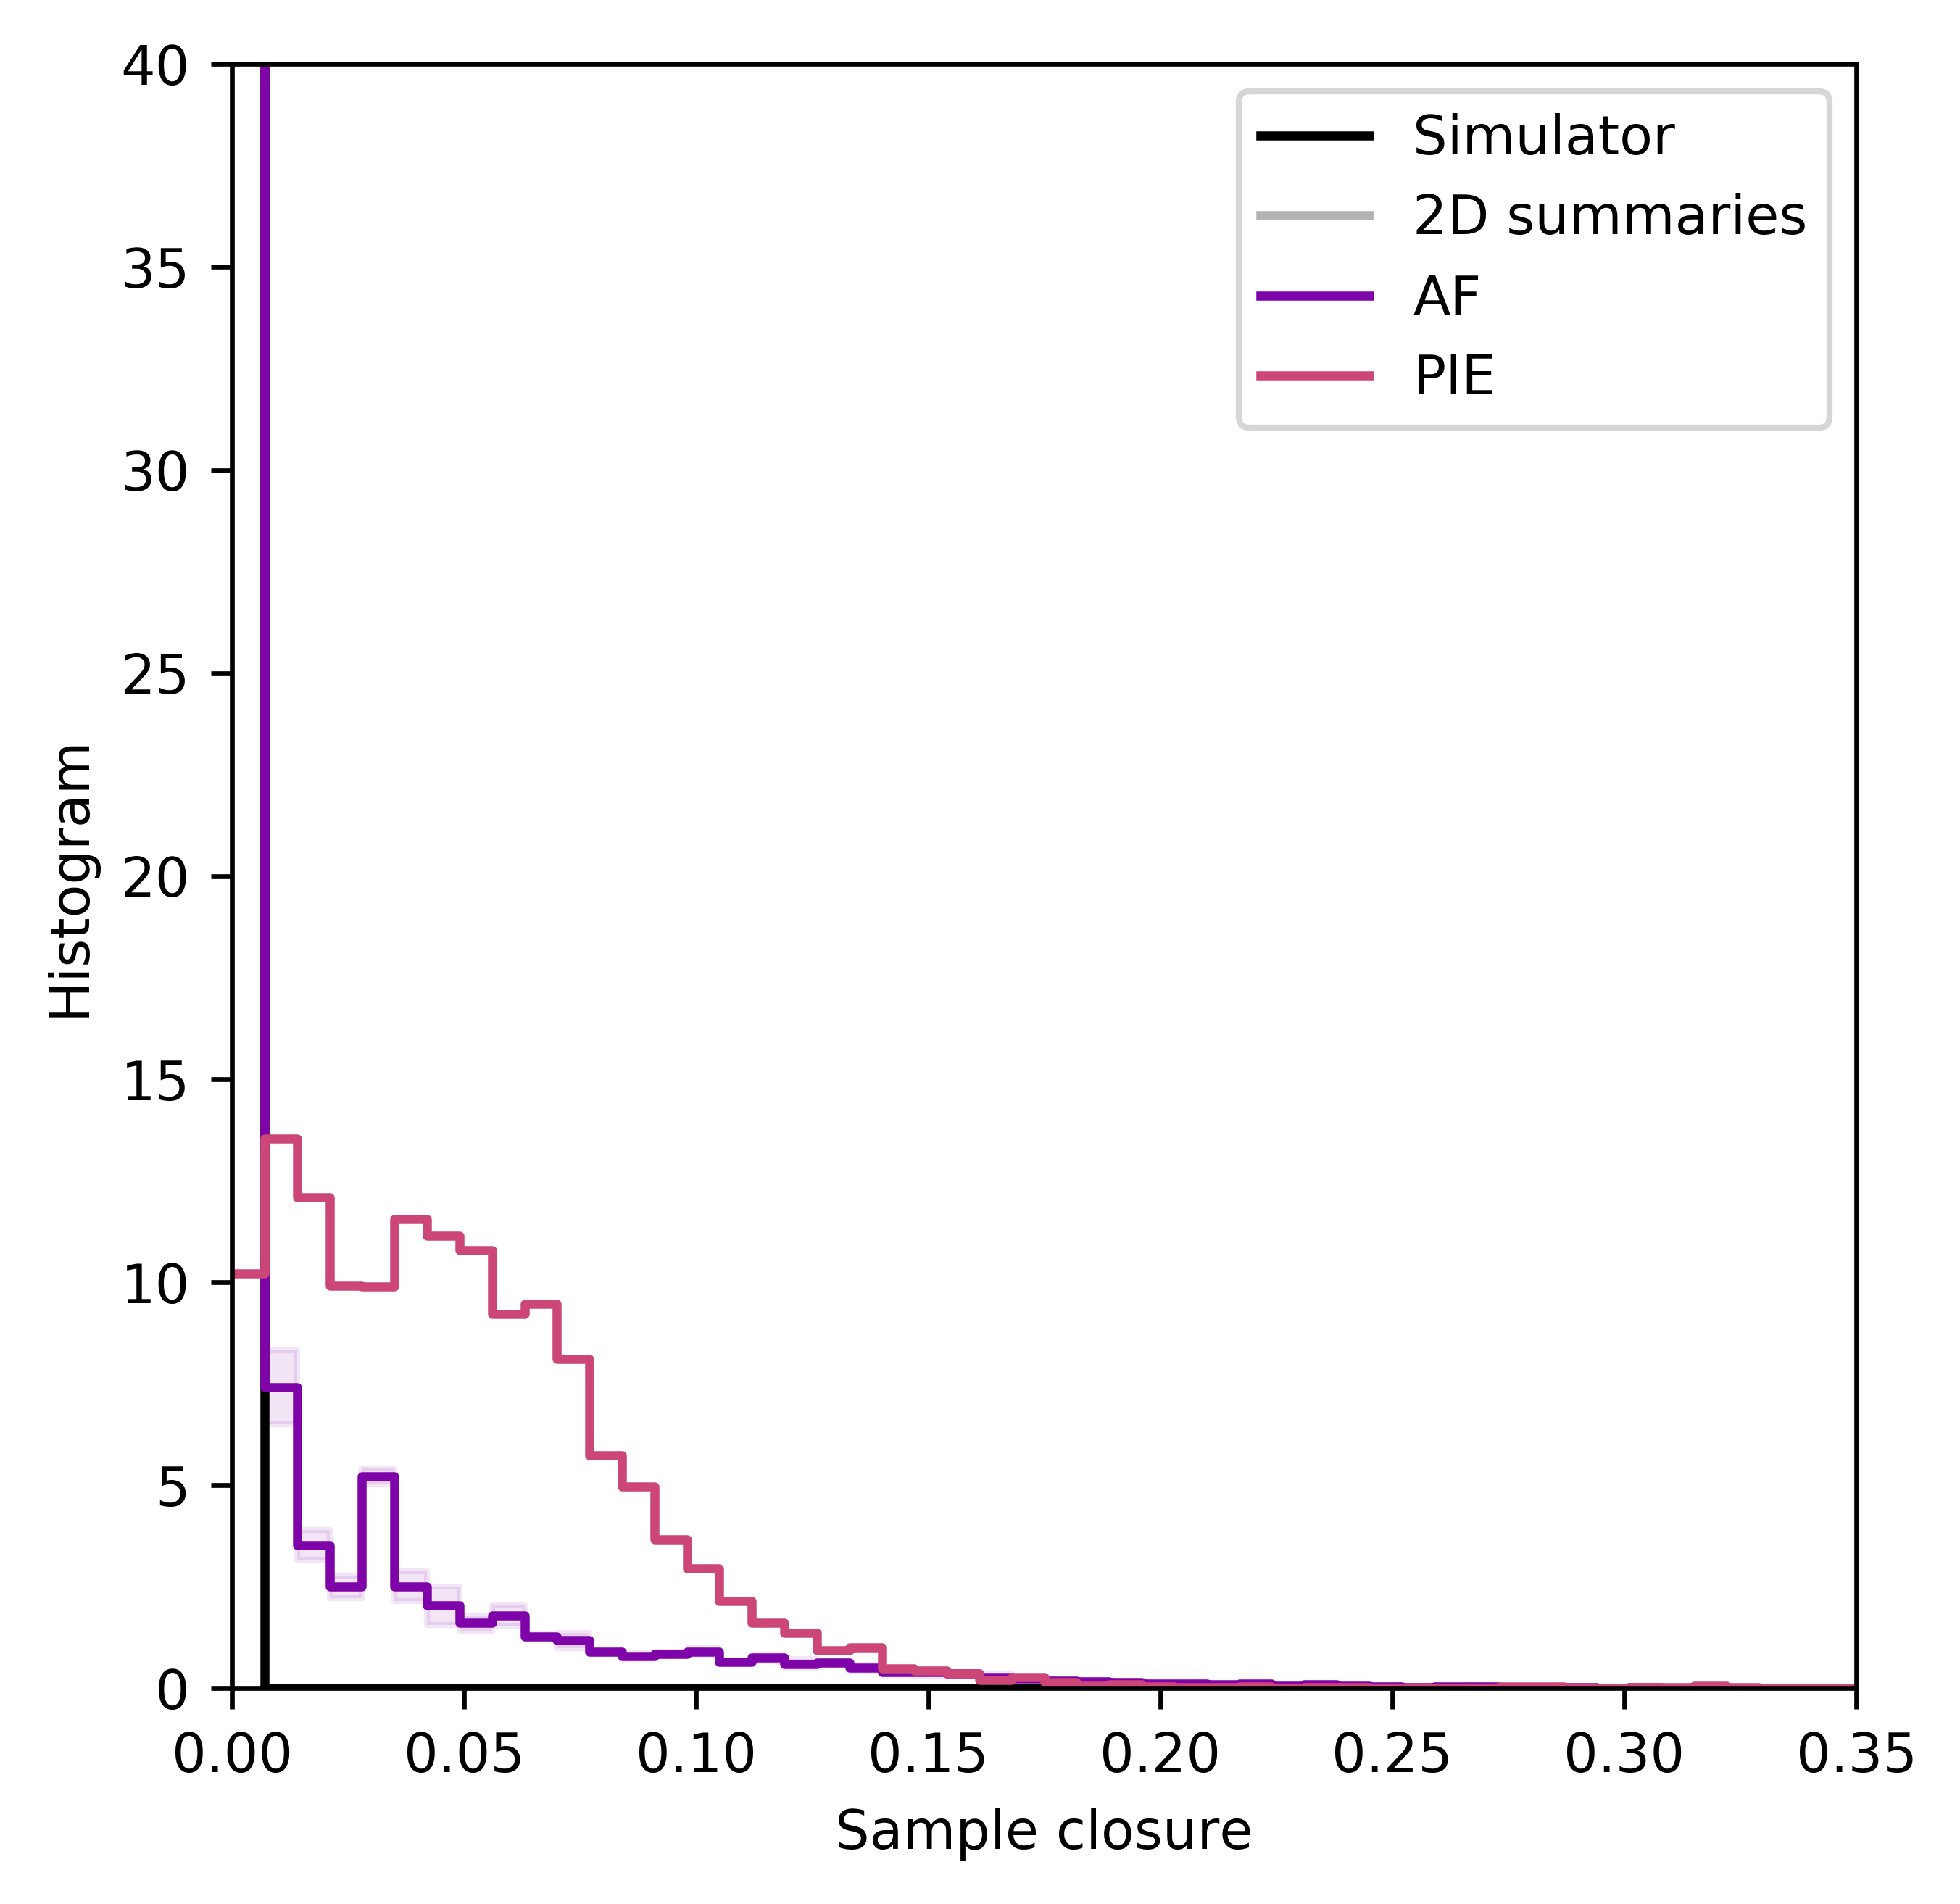

In [42]:
xmin, xmax = 0.,0.35
bins = 50

fig, ax = ps.figure()
    
histo_w_err(
    test_closure,
    xmin, xmax, bins,
    label="Simulator",
    c="black",
)

for closure, algo_label, c, m, ls in zip(model_gen_closure, algo_labels, algo_colors, algo_markers, algo_linestyles):
    histo_w_err(
        closure,
        xmin, xmax, bins,
        label=algo_label,
        c=c,
        ls=ls,
    )

plt.legend()

plt.xlabel(r"Sample closure")
plt.ylabel(r"Histogram")
plt.xlim(xmin, xmax)
plt.ylim(0., 40.)
#plt.yscale("log")
#plt.ylim(1.e-2, 2.e2)

plt.savefig("../figures/lhc_generated_samples_closure.pdf")


## Posterior plots

In [43]:
model_posterior_samples.shape

(3, 5, 3, 4, 500, 2)

In [44]:
madminer_mcmc_samples.shape

(3, 4, 500, 2)

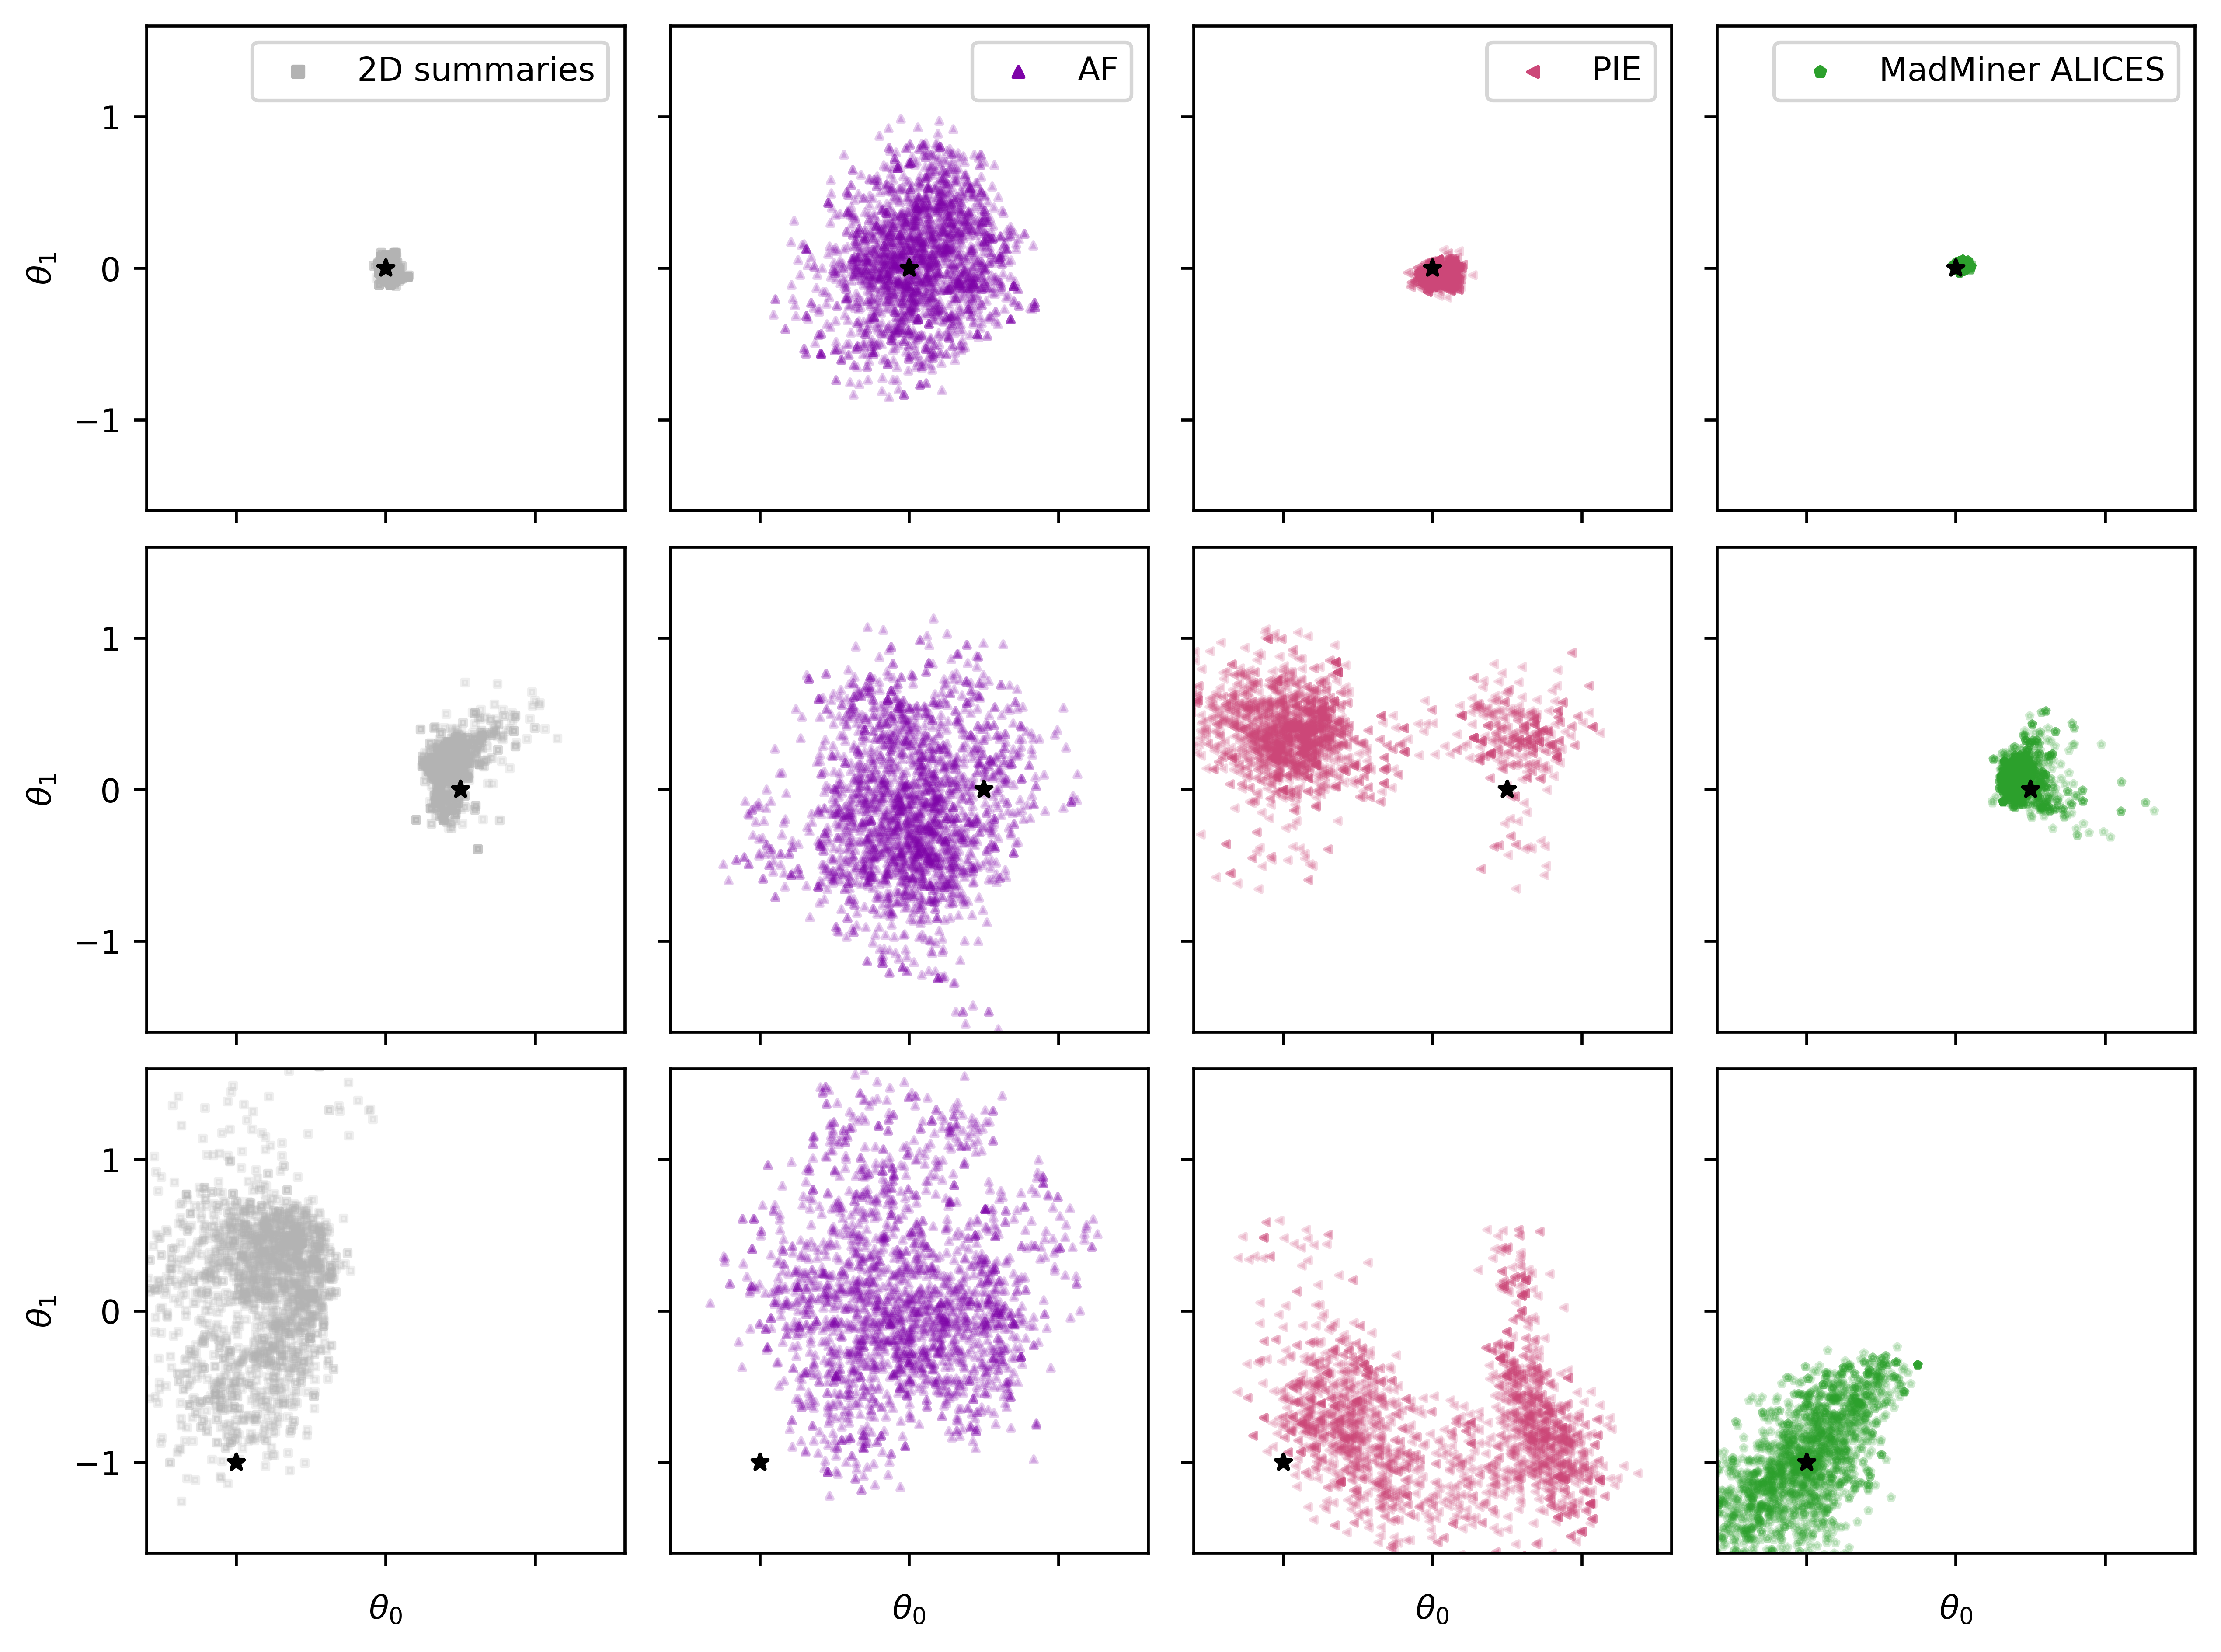

In [48]:
skip = 1

ncols = n_trueparams
nrows = 2
true_params = [[0.,0.], [0.5, 0.], [-1., -1.]]

fig, gs = ps.grid_width(n_panels, n_trueparams, width=ps.TEXTWIDTH)

for i in range(n_panels):
    for j in range(n_trueparams):
        ax = plt.subplot(gs[j*n_panels + i])
    
        # True point
        plt.scatter(
            true_params[j][0], true_params[j][1], marker="*", s=20, color="black", zorder=5.
        )
        
        # Results
        for label, posteriors, c, m, panel, run  in zip(
            algo_labels, model_posterior_samples, algo_colors, algo_markers, algo_panels, algo_best_runs
        ):
            if panel < 0 or panel == i:
                plt.scatter(
                    posteriors[run,j,:,::skip, 0], posteriors[run,j,:,::skip, 1],
                    c=[c], marker=m, s=3., alpha=0.2
                )
        
        # MadMiner
        if i == n_panels - 1:
            plt.scatter(
                madminer_mcmc_samples[j, :, ::skip, 0], madminer_mcmc_samples[j, :, ::skip, 1],
                c=["C2"], marker="p", s=3., alpha=0.2
            )

        plt.xlim(-1.6,1.6)
        plt.ylim(-1.6,1.6)
        plt.xticks([-1., 0., 1.], None if j == n_panels - 1 else ["", "", ""])
        plt.yticks([-1., 0., 1.], None if i == 0 else ["", "", ""])
        plt.xlabel(r"$\theta_0$" if j == n_algos - 1 else "")
        plt.ylabel(r"$\theta_1$" if i == 0 else "")
        
        # Legend
        if j == 0:
            # ax = plt.subplot(gs[i*(n_trueparams + 1) + n_trueparams])
            # plt.scatter([], [], marker="*", s=20, color="black", label=r"$\theta^*$")
            for label, posteriors, c, m, panel  in zip(
                algo_labels, model_posterior_samples, algo_colors, algo_markers, algo_panels
            ):
                if panel < 0 or panel == i:
                    plt.scatter([], [], c=[c], marker=m, s=8., label=label)
            
            if i == (n_panels - 1):
                plt.scatter([],[], c=["C2"], marker="p", s=8., label="MadMiner ALICES")
            plt.legend(loc="upper right")
            # plt.legend(loc="center left", frameon=False)
            # plt.axis("off")

plt.savefig("../figures/lhc_posterior_scatter.pdf")


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib

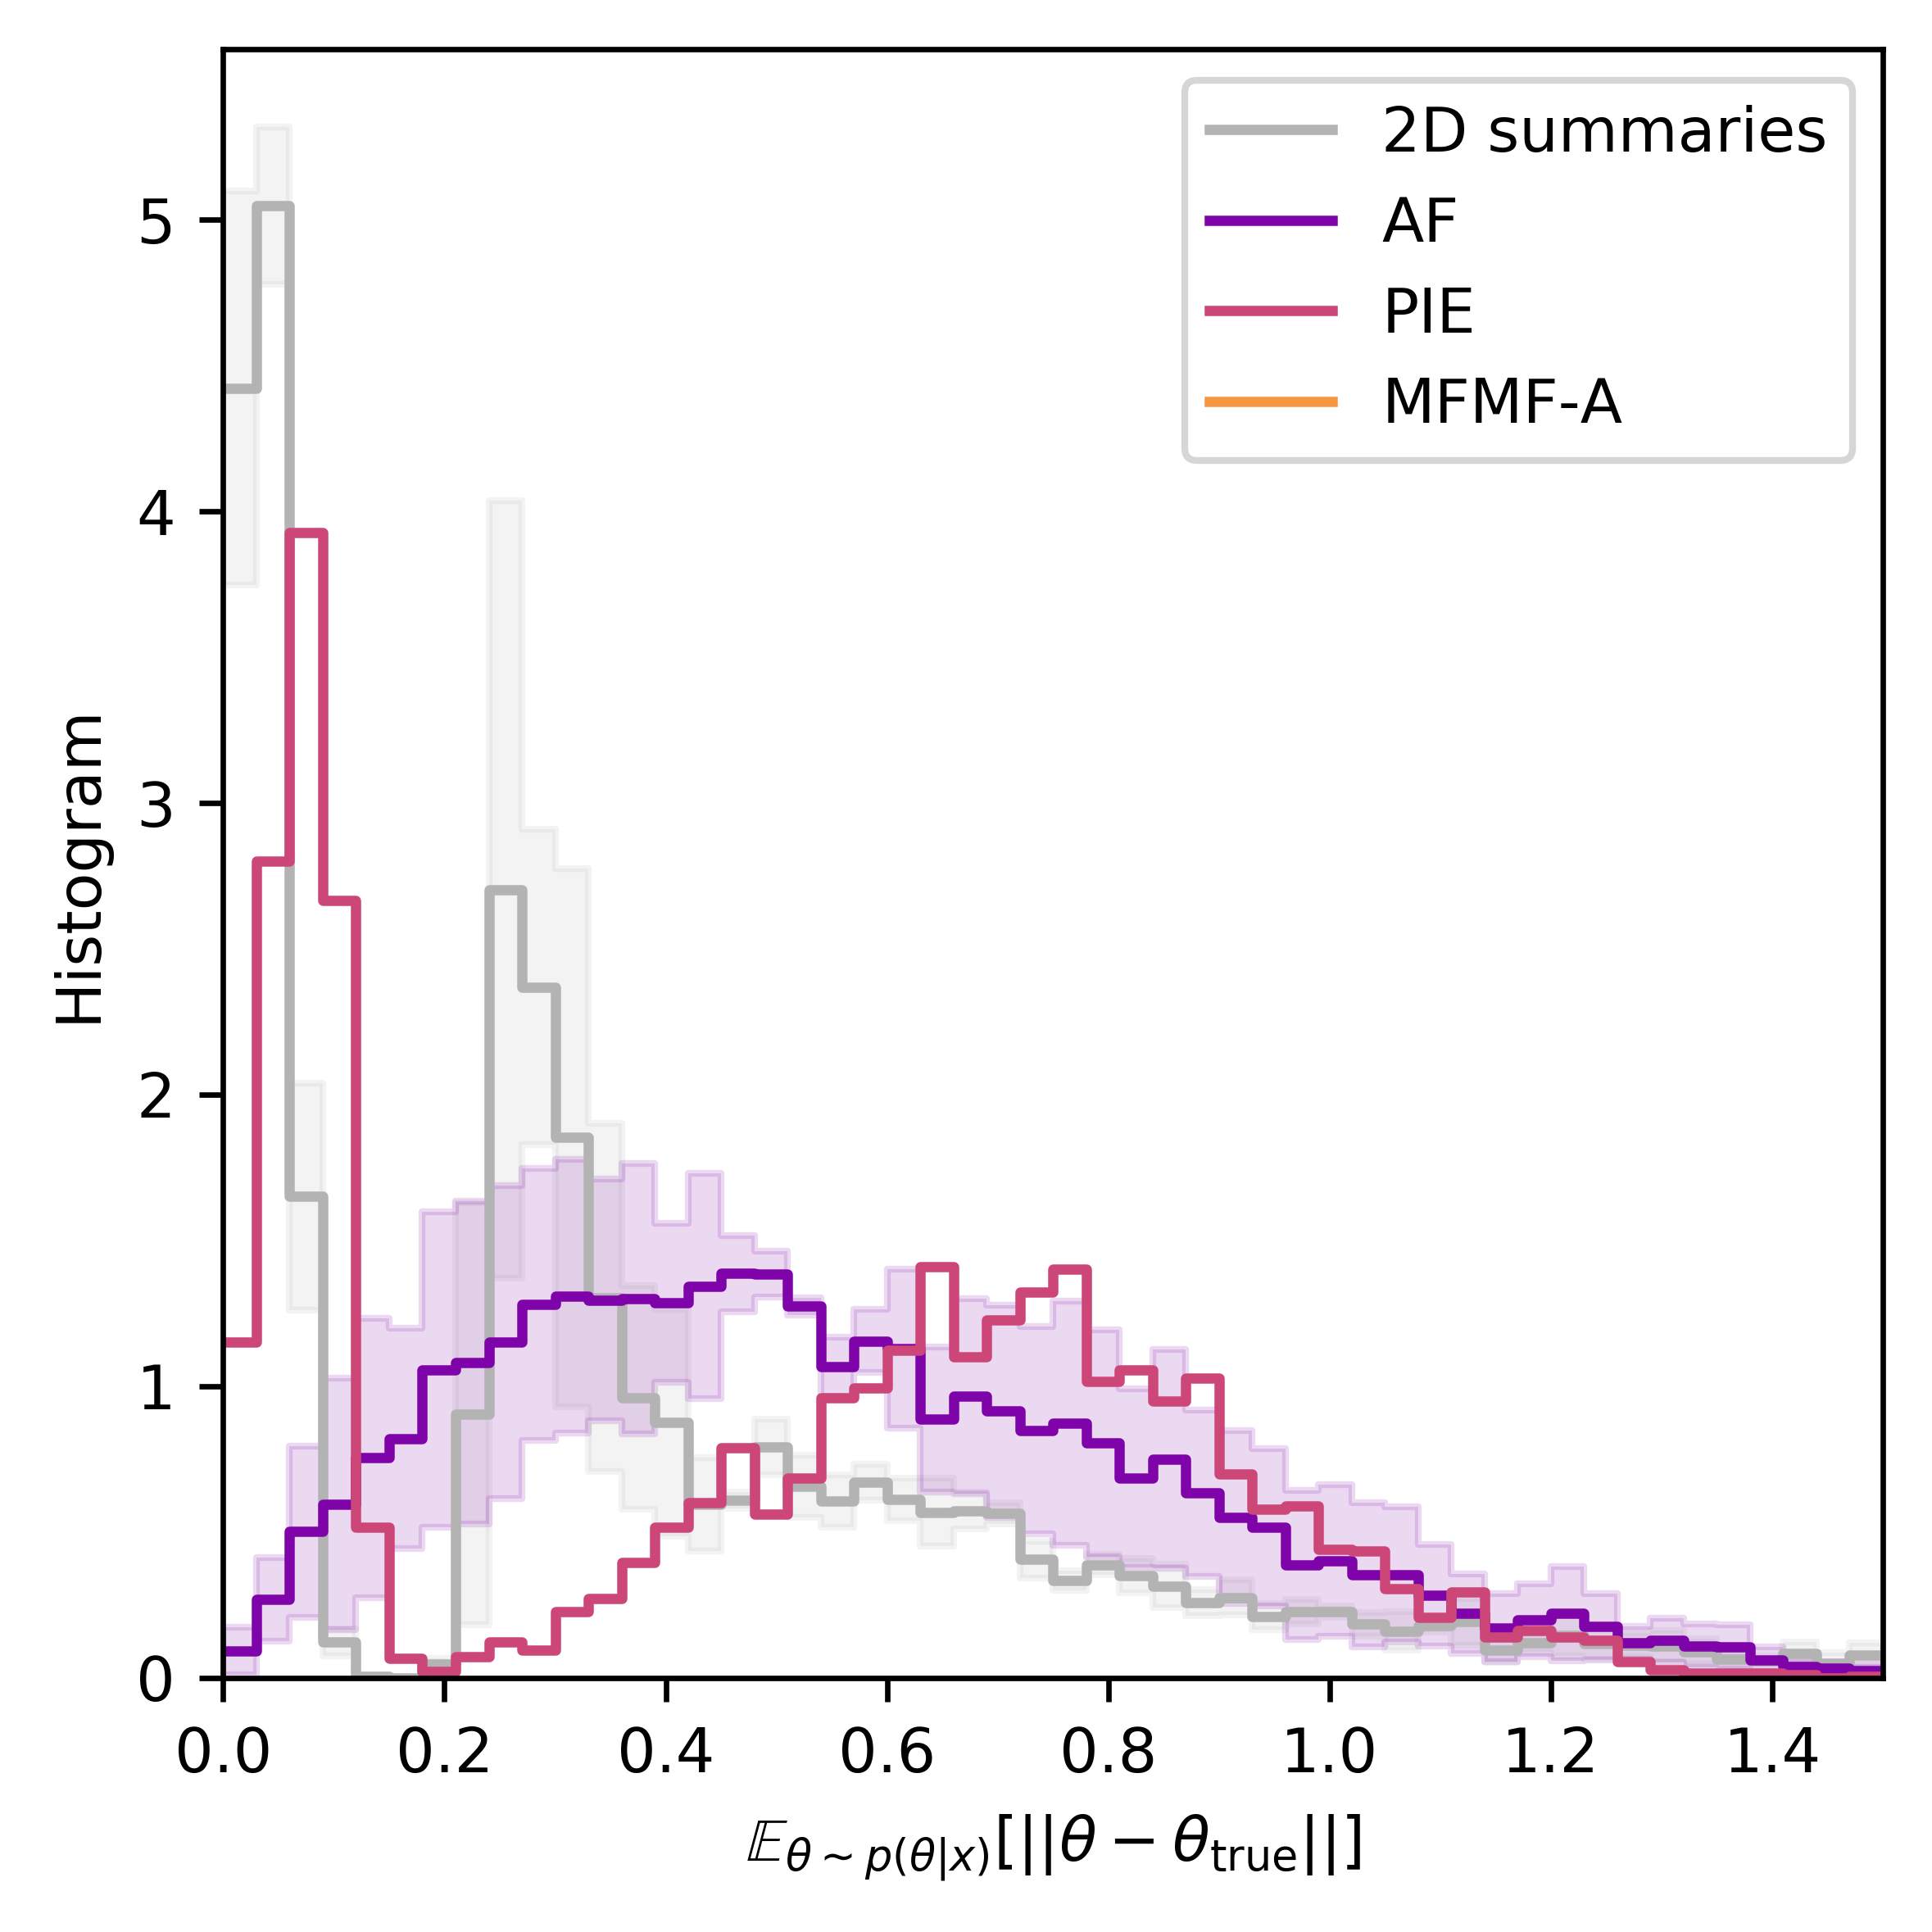

In [13]:
dmin, dmax = 0., 1.5

fig = plt.figure(figsize=(4.,4.))

for i, (label, samples, c, ls) in enumerate(zip(algo_labels, model_posterior_samples, algo_colors, algo_linestyles)):
    posterior_diffs = np.mean(samples**2, axis=-1)**0.5
    
    histo_w_err(posterior_diffs, dmin, dmax, 50, c=c, ls=ls, alpha=0.15, label=label)
    plt.legend()
    
    plt.xlim(dmin, dmax)
    plt.ylim(0., None)

    plt.xlabel(r"$\mathbb{E}_{\theta \sim p(\theta | x)} [ || \theta - \theta_\mathrm{true} || ]$")
    plt.ylabel("Histogram")

plt.tight_layout()
plt.savefig("../figures/lhc_posterior_distance.pdf")
